# Implement a 4x4 gridworld, find terminal with DP


<u>Group:</u><br>
$383321$<br>
$0709942R$
$2373769$ <br>
$2376182$<br>

In [1]:
from copy import deepcopy
from enum import Enum
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Gridworld
Gridworld for a simple finite MDP. Only actions with movements in cardinal directions are allowed.<br>
And the gird boundaries and obstacles are inaccessible by the agent.

In [2]:
class CellType(Enum):
    SPACE = 0
    OBSTACLE = 1
    
class Actions(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

class State(object):
    def __init__(self, row, col):
        self.row = row
        self.col = col
        
    def __eq__(self, other):
        return self.row == other.row and self.col == other.col
    
    def __str__(self):
        return str((self.row, self.col))
    
        
class GridWorld(object):   
    def __init__(self, height=4, width=4):
        self.goal  = State(0, 0)
        self.environment = self._init_environment(height, width, True)
        self.rewards = self._init_rewards(self.environment)
        self.shape = (len(self.environment),len(self.environment[0]))
        
    # Add agent to environment using 4 as agen't position
    def __str__(self):
        environment = self.environment.copy()
        environment[self.agent_state.row, self.agent_state.col] = 4
        return str(environment)
        
        
    def _init_rewards(self, environment):
        rewards = {}
        for row in range(len(environment)):
            for col in range(len(environment[row,:])):
                if environment[row, col] != CellType.OBSTACLE.value:
                    cardinal_states = self.get_cardinal_states(State(row, col))
                    rewards[row, col] = {}
                    for neighbour in cardinal_states:
                        reward = -1
                        if neighbour == self.goal:
                            reward = 20
                        rewards[row, col][neighbour.row, neighbour.col] = reward
        return rewards
    
                    
    def _init_environment(self, height, width, no_obstacles = False):
        environment = []
        for row in range(height):
            new_col = []
            for col in range(width):         
                new_col.append(CellType.SPACE.value)
            environment.append(new_col)
        return np.flip(np.array(environment),axis=0)
    
    def get_agent_state(self, agent):
        return self.agent_state
    
    def get_cardinal_states(self, state):
        return [State(state.row + 1, state.col), State(state.row - 1, state.col),
                State(state.row, state.col + 1), State(state.row, state.col - 1)]

    
    def get_all_actions(self):
        return [Actions.DOWN, Actions.UP, Actions.LEFT, Actions.RIGHT]
    
    def get_action_state_prob(self, state):
        count = 0
        if state.row > 0:
            count += 1
        if state.row < len(self.environment) -1:
            count += 1
        if state.col > 0:
            count += 1
        if state.col < len(self.environment) -1:
            count += 1
        return 1/count
            
        return [Actions.DOWN, Actions.UP, Actions.LEFT, Actions.RIGHT]
    
    def state_reward_from_action(self, state, action): 
        from_state = state
        if action == Actions.DOWN:
            if state.row == len(self.environment) - 1:
            #Grid boundary, go nowhere, penalise
                return state, -1
            else:
                new_state = State(state.row + 1, state.col)
        if action == Actions.UP:
            if state.row == 0:
            #Grid boundary, go nowhere, penalise
                return state, -1
            else:
                new_state = State(state.row - 1, state.col)       
        if action == Actions.LEFT:
            if state.col == 0:
            #Grid boundary, go nowhere, penalise
                return state, -1
            else:
                new_state = State(state.row, state.col - 1)
        if action == Actions.RIGHT:
            if state.col == len(self.environment) - 1:
            #Grid boundary, go nowhere, penalise
                return state, -1 
            else:
                new_state = State(state.row, state.col + 1)
                
        return new_state, self.rewards[from_state.row, from_state.col][new_state.row, new_state.col]     

## Two-array policy evalution

$v_0$ is intialized arbitrarily, except the terminal state, must be given value 0.

In [3]:
def two_array_policy_eval(grid_world, gamma= 1.0, pi= 0.01):
    # Start with a arbitrary (all 0) value function
    v_prev = np.zeros(grid_world.shape)
    loop_count = 0
    while True:
        delta = - float('inf')
        loop_count += 1          
            
        #new value function
        v_new = np.zeros(grid_world.shape)

        #Loop through all states (Env cells)
        for row in range (grid_world.shape[0]): 
            for col in range(grid_world.shape[1]):
                
                if State(row, col) == grid_world.goal:
                    continue
                    
                # Make 0, so we can recompute
                v_new[row, col] = 0
                
                # Uniform action probabilities
                val_prob = grid_world.get_action_state_prob(State(row, col))
                
                #loop over possible actions
                for action in grid_world.get_all_actions():
                
                    #get transitions
                    new_state, reward = grid_world.state_reward_from_action(State(row, col), action)
                    
                    # No state change -> Zero prob
                    if new_state == State(row,col):
                        prob = 0
                    else:
                        prob = val_prob 
                        
                    #Update value for this action
                    v_new[row, col] += prob * (reward + gamma * v_prev[new_state.row, new_state.col])                

                delta = max(delta, abs(v_new[row, col] - v_prev[row, col]))
                
        # If the biggest change is less than the threshold, its time to leave this joint
        if(delta < pi):
            break

        v_prev = v_new

    return v_new, loop_count




2-Array iterations: 180


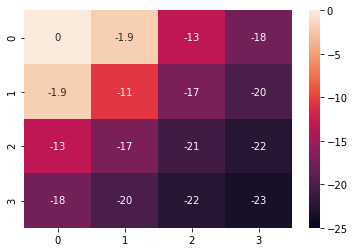

In [8]:
grid_world = GridWorld()
v, loop_count = two_array_policy_eval(grid_world)
print("2-Array iterations: " + str(loop_count))
sns.heatmap(v,vmin=-25,annot=True);

## In-place policy evalution

$v_0$ is intialized arbitrarily, except the terminal state, must be given value 0.

In [5]:
def in_place_policy_eval(grid_world, gamma= 1.0, pi= 0.01):
    # Start with a arbitrary (all 0) value function
    v = np.zeros(grid_world.shape)
    loop_count = 0
    v_prev = np.zeros(grid_world.shape)
    
    while True:
        
        delta = - float('inf')
        loop_count += 1
        
        # Loop through all states (Env cells)
        for row in range(grid_world.shape[0]):
            for col in range(grid_world.shape[1]):

                if State(row, col) == grid_world.goal:
                    continue
                    
                
                # Make 0, so we can recompute
                v[row, col] = 0
                
                # Uniform action probabilities
                val_prob = grid_world.get_action_state_prob(State(row, col))

                for action in grid_world.get_all_actions():
                    # get transitions
                    new_state, reward = grid_world.state_reward_from_action(State(row, col), action)
                    
                    if new_state == State(row,col):
                        prob = 0
                    else:
                        prob = val_prob
                                
                    v[row, col] +=  prob * (reward + gamma * v[new_state.row, new_state.col])
                
                delta = max(delta, abs(v[row, col] - v_prev[row, col]))
                
        # If the biggest change is less than the threshold, its time to leave this joint
        if (delta < pi):
            break  
            
        v_prev = v
        
    return np.array(v), loop_count

In-place iterations: 2


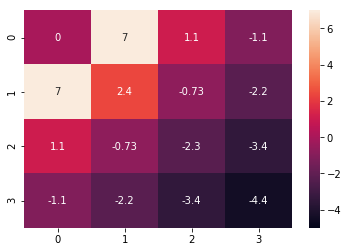

In [9]:
grid_world = GridWorld()
v, loop_count = in_place_policy_eval(grid_world)
print("In-place iterations: " + str(loop_count))
sns.heatmap(v,vmin=-5,annot=True);